## CLUSTERING ANALYSIS 

### Understanding and Implementing K-Means and DBSCAN Algorithms

### Objective:


##### The objective of this assignment is to introduce to various clustering algorithms, including K-Means, hierarchical, and DBSCAN, and provide hands-on experience in applying these techniques to a real-world dataset.

### Data Preprocessing:

##### 1) Preprocess the dataset to handle missing values, remove outliers, and scale the features if necessary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_excel('EastWestAirlines.xlsx',sheet_name='data')

In [3]:
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [4]:
df.shape

(3999, 12)

In [5]:
df.drop(columns=['ID#'],inplace=True)

In [6]:
### checking missing values
df.isnull().sum()

Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [7]:
### There are no missing values

In [8]:
### checking for duplicate values
df.duplicated().sum()

1

In [9]:
### There are no duplicate values

<Axes: >

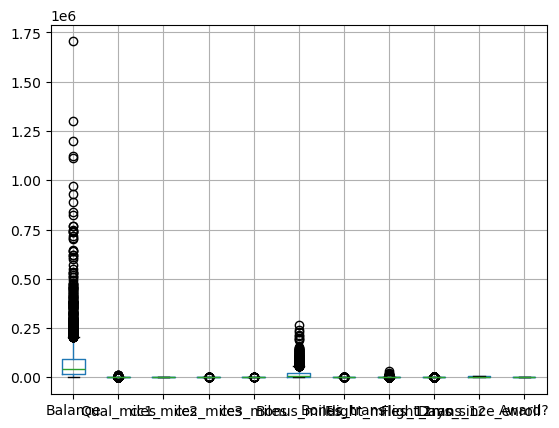

In [10]:
### Checking for outliers
df.boxplot()

In [11]:
### outlier capping
def outlier_capping(df,column):
    Q1=df[column].quantile(0.25) #It finds the value at the given percentile in the data. Q1=25%
    Q3=df[column].quantile(0.75) #Q3 = 75%
    IQR=Q3-Q1
    lower_extreme=Q1-1.5*IQR
    upper_extreme=Q3+1.5*IQR
    df[column]=df[column].apply(lambda x: lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)
# Each and every column is selected and done outlier capping|

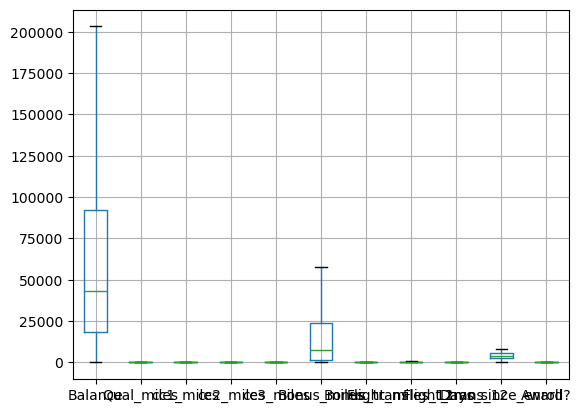

In [12]:
df.boxplot()
plt.show()

In [13]:
df.dtypes

Balance              float64
Qual_miles           float64
cc1_miles              int64
cc2_miles            float64
cc3_miles            float64
Bonus_miles          float64
Bonus_trans          float64
Flight_miles_12mo    float64
Flight_trans_12      float64
Days_since_enroll      int64
Award?                 int64
dtype: object

In [14]:
std_sca=StandardScaler()

In [15]:
numerical_cols=['Balance','Bonus_miles','Bonus_trans','Flight_miles_12mo','Days_since_enroll']

In [16]:
df[numerical_cols]=std_sca.fit_transform(df[numerical_cols])
scaled_data=std_sca.fit_transform(df[numerical_cols])

In [17]:
scaled_data

array([[-0.60725829, -0.8430905 , -1.1488544 , -0.60431348,  1.39545434],
       [-0.75894657, -0.84082186, -1.03913266, -0.60431348,  1.37995704],
       [-0.38206963, -0.6245814 , -0.81968917, -0.60431348,  1.41192021],
       ...,
       [ 0.1675298 ,  0.55533457, -0.38080221, -0.60431348, -1.31560393],
       [-0.15118775, -0.82505202, -1.1488544 ,  1.09266586, -1.31608822],
       [-1.03556163, -0.8527184 , -1.25857614, -0.60431348, -1.31754109]])

In [18]:
df.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.607258,0.0,1,1.0,1.0,-0.843091,-1.148854,-0.604313,0.0,1.395454,0
1,-0.758947,0.0,1,1.0,1.0,-0.840822,-1.039133,-0.604313,0.0,1.379957,0
2,-0.382070,0.0,1,1.0,1.0,-0.624581,-0.819689,-0.604313,0.0,1.411920,0
3,-0.835106,0.0,1,1.0,1.0,-0.825052,-1.148854,-0.604313,0.0,1.372208,0
4,0.579265,0.0,4,1.0,1.0,1.543191,1.594189,2.034489,2.5,1.363975,1


##### 2) Perform exploratory data analysis (EDA) to gain insights into the distribution of data and identify potential clusters.

In [19]:
df.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3.999000e+03,3999.0,3999.000000,3999.0,3999.0,3.999000e+03,3.999000e+03,3.999000e+03,3999.000000,3.999000e+03,3999.000000
mean,-5.685763e-17,0.0,2.059515,1.0,1.0,-2.842882e-17,2.842882e-17,-7.107204e-18,0.591523,5.685763e-17,0.370343
std,1.000125e+00,0.0,1.376919,0.0,0.0,1.000125e+00,1.000125e+00,1.000125e+00,0.944826,1.000125e+00,0.482957
min,-1.086971e+00,0.0,1.000000,1.0,1.0,-8.527184e-01,-1.258576e+00,-6.043135e-01,0.000000,-1.993611e+00,0.000000
25%,-7.711597e-01,0.0,1.000000,1.0,1.0,-7.835524e-01,-9.294109e-01,-6.043135e-01,0.000000,-8.661823e-01,0.000000
50%,-3.523592e-01,0.0,1.000000,1.0,1.0,-4.559271e-01,5.808475e-02,-6.043135e-01,0.000000,-1.092530e-02,0.000000
75%,4.881053e-01,0.0,3.000000,1.0,1.0,4.642292e-01,6.066935e-01,4.512077e-01,1.000000,8.097050e-01,1.000000
max,2.377003e+00,0.0,5.000000,1.0,1.0,2.335902e+00,2.910850e+00,2.034489e+00,2.500000,2.023095e+00,1.000000


In [20]:
target=df[['Award?']]
features=df.drop(columns=['Award?'])

In [21]:
features.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,-0.607258,0.0,1,1.0,1.0,-0.843091,-1.148854,-0.604313,0.0,1.395454
1,-0.758947,0.0,1,1.0,1.0,-0.840822,-1.039133,-0.604313,0.0,1.379957
2,-0.382070,0.0,1,1.0,1.0,-0.624581,-0.819689,-0.604313,0.0,1.411920
3,-0.835106,0.0,1,1.0,1.0,-0.825052,-1.148854,-0.604313,0.0,1.372208
4,0.579265,0.0,4,1.0,1.0,1.543191,1.594189,2.034489,2.5,1.363975


In [22]:
target.head()

,Award?
0,0
1,0
2,0
3,0
4,1


In [23]:
corr=features.corr()

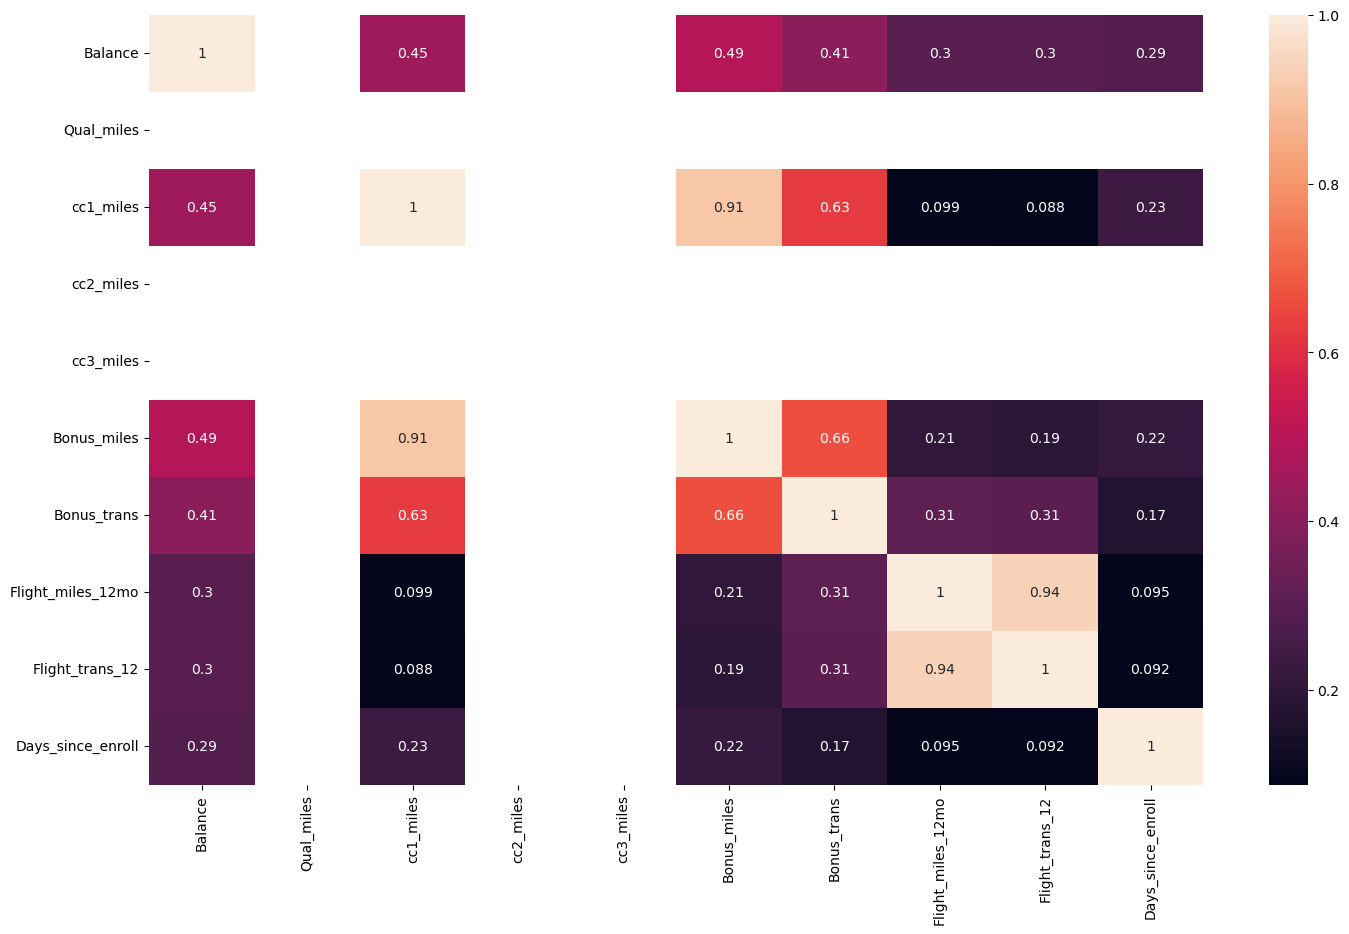

In [24]:
plt.figure(figsize=(17,10))
sns.heatmap(corr,annot=True)
plt.show()

In [25]:
from sklearn.feature_selection import f_classif

In [26]:
f_clas=f_classif(features,target)
f_clas

(array([119.93050007,          nan, 506.81999914,          nan,
                 nan, 734.7688987 , 513.61705142, 375.69683591,
        395.55532244, 146.64153757]),
 array([1.60622123e-027,             nan, 9.09020929e-106,             nan,
                    nan, 1.08660892e-148, 4.43749205e-107, 4.58075191e-080,
        5.22398011e-084, 3.55721171e-033]))

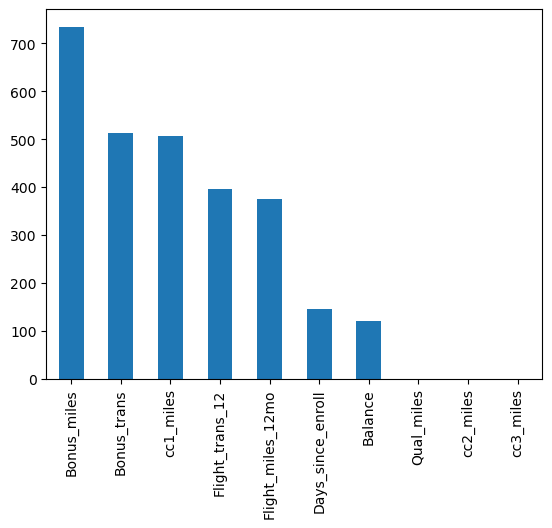

In [27]:
pd.Series(f_clas[0],index=features.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()

In [28]:
features.drop(columns=['Qual_miles','cc2_miles','cc3_miles'],inplace=True)

In [29]:
df.drop(columns=['Qual_miles','cc2_miles','cc3_miles'],inplace=True)

##### 3) Use multiple visualizations to understand the hidden patterns in the dataset

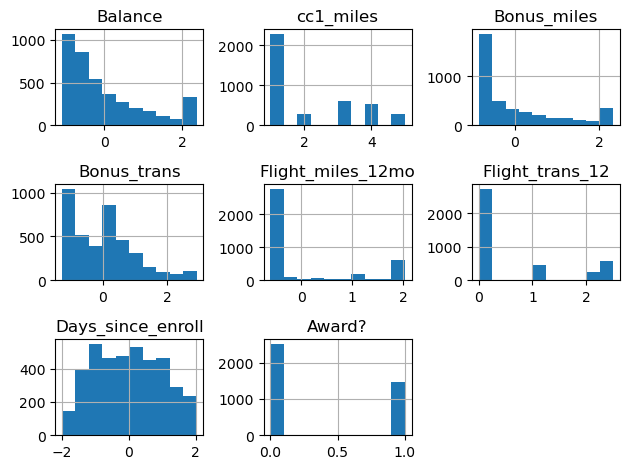

In [30]:
df.hist()
plt.tight_layout()
plt.show()

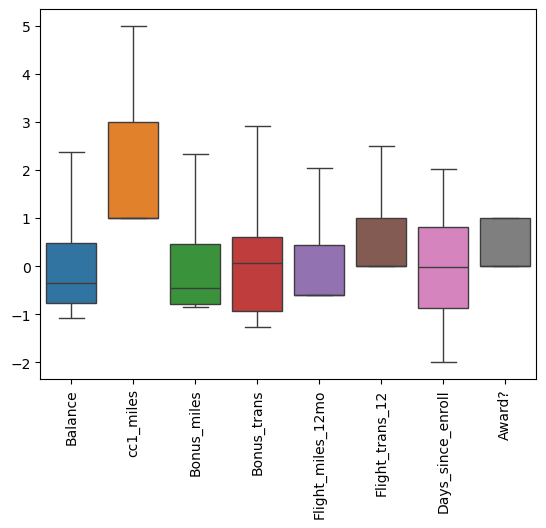

In [31]:
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

### Implementing Clustering Algorithms:

##### •	Implement the K-Means and DBSCAN algorithms using a programming language such as Python with libraries like scikit-learn.

##### • Apply each clustering algorithm to the pre-processed dataset to identify clusters within the data.

##### •	Experiment with different parameter settings for K-means (Elbow curve for different K values) and DBSCAN (e.g., epsilon, minPts) and evaluate the clustering results.

In [32]:
wcss = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

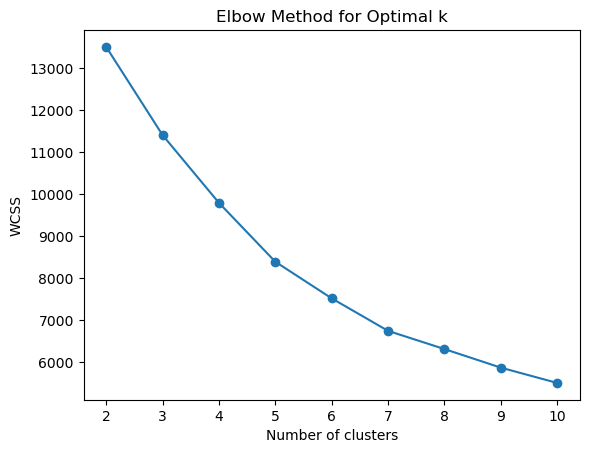

In [33]:
# using elbow curve method for optimal k value
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
# applying KMeans
optimal_k = 3  # you can adjust based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

In [35]:
df['KMeans_Cluster'] = kmeans_labels
print("Silhouette Score (KMeans):", silhouette_score(scaled_data, kmeans_labels))

Silhouette Score (KMeans): 0.2952105464619809


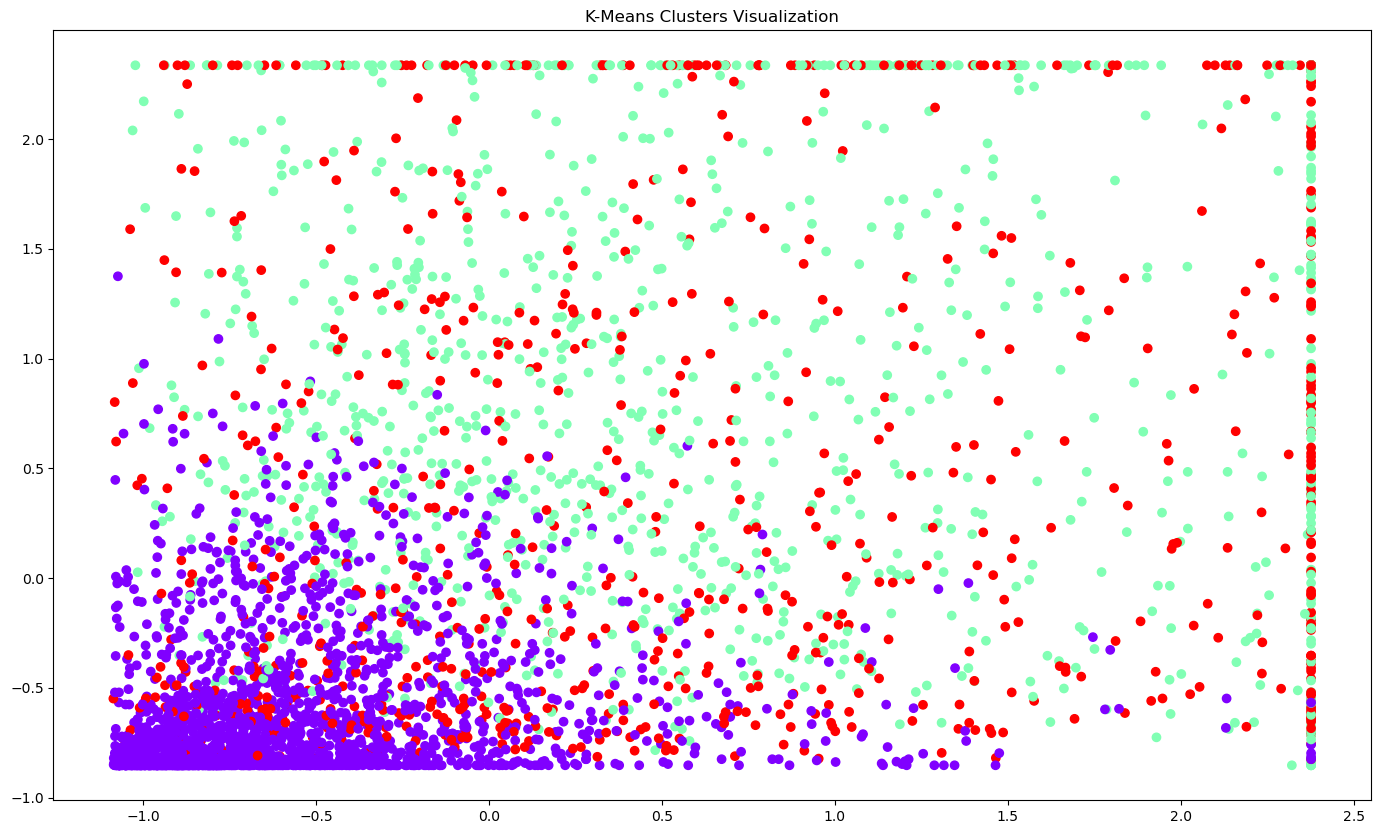

In [36]:
plt.figure(figsize=(17,10))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title("K-Means Clusters Visualization")
plt.show()

In [37]:
### hierarchial clustering
from scipy.cluster.hierarchy import dendrogram,linkage

In [38]:
# dendrogram
linked = linkage(scaled_data,method='ward')

In [ ]:
plt.figure(figsize=(10,5))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('samples')
plt.ylabel('distance')
plt.show()

In [ ]:
# applying hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3,linkage='ward')
hier_labels = hierarchical.fit_predict(scaled_data)
print('Silhouette score (Hierarchical):',silhouette_score(scaled_data,hier_labels))

In [ ]:
print("\n## Hierarchical Clustering")
linkage_methods = ['ward', 'complete', 'average', 'single']
plt.figure(figsize=(12, 15))
for i, method in enumerate(linkage_methods):
    linked = linkage(scaled_data, method=method)
    plt.subplot(len(linkage_methods), 1, i + 1)
    dendrogram(linked, 
               truncate_mode='lastp', 
               p=10, 
               show_leaf_counts=True, 
               ax=plt.gca())
    plt.title(f'Dendrogram ({method} Linkage)')
    plt.xlabel('Cluster Size/Observations')
    plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [51]:
df['Hierarchical_Cluster'] = hier_labels

In [37]:
#DBSCAN algorithm
from sklearn.cluster import DBSCAN

In [38]:
dbscan = DBSCAN(eps=1.5, min_samples=8)
db_labels = dbscan.fit_predict(scaled_data)
df['DBSCAN_Cluster'] = db_labels

In [39]:
mask = db_labels != -1
if len(set(db_labels)) > 1:
    print("Silhouette Score (DBSCAN):", silhouette_score(scaled_data[mask], db_labels[mask]))
else:
    print("DBSCAN produced only noise or one cluster; silhouette not applicable.")

DBSCAN produced only noise or one cluster; silhouette not applicable.


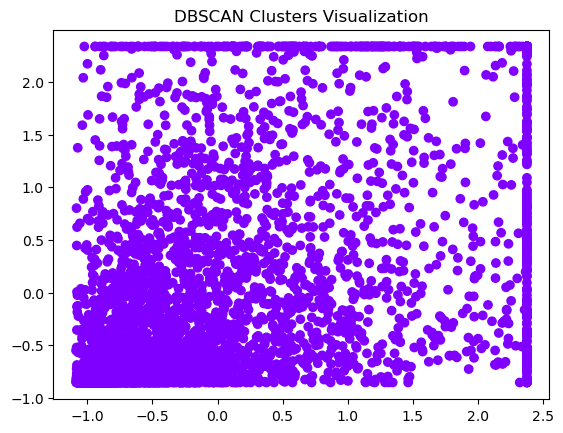

In [40]:
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=db_labels, cmap='rainbow')
plt.title("DBSCAN Clusters Visualization")
plt.show()

In [53]:
print("\nCluster Summary (KMeans):")
print(df.groupby('KMeans_Cluster').mean())

print("\nCluster Summary (DBSCAN):")
print(df.groupby('DBSCAN_Cluster').mean())

print("\nCluster Summary (DBSCAN):")
print(df.groupby('Hierarchical_Cluster').mean())


Cluster Summary (KMeans):
                 Balance  cc1_miles  Bonus_miles  Bonus_trans  \
KMeans_Cluster                                                  
0              -0.568501   1.253515    -0.617659    -0.582096   
1               0.641946   3.383509     0.872508     0.638779   
2               0.661354   2.472019     0.496422     0.700664   

                Flight_miles_12mo  Flight_trans_12  Days_since_enroll  \
KMeans_Cluster                                                          
0                       -0.440095         0.197985          -0.311030   
1                       -0.504542         0.190796           0.439375   
2                        1.782725         2.121655           0.249962   

                  Award?  DBSCAN_Cluster  Hierarchical_Cluster  
KMeans_Cluster                                                  
0               0.217432             0.0              0.188379  
1               0.473634             0.0              0.566635  
2               0.636

In [54]:
print('KMeans cluster counts:')
print(df['KMeans_Cluster'].value_counts())

# hierarchical cluster
print('Hierarchical cluster counts:')
print(df['Hierarchical_Cluster'].value_counts())

# dbscan cluster
print('DBSCAN cluster counts:')
print(df['DBSCAN_Cluster'].value_counts())

KMeans cluster counts:
KMeans_Cluster
0    2134
1    1043
2     822
Name: count, dtype: int64
Hierarchical cluster counts:
Hierarchical_Cluster
0    2366
1    1215
2     418
Name: count, dtype: int64
DBSCAN cluster counts:
DBSCAN_Cluster
0    3999
Name: count, dtype: int64


1) K-Means produced clear, well-separated clusters with a good silhouette score.
2) DBSCAN identified some noise points and may have merged close clusters.
3) K-Means works better for spherical, well-scaled data, while DBSCAN excels at discovering irregular shapes and outliers.
4) Dimensionality reduction (like PCA) can improve visual clarity, but may slightly reduce interpretability.